# Malicious URL Detection Using Machine Learning

## Importing Libraries

In [3]:
# Standard Libraries:
import re # To handle regular expressions
import numpy as np # Numerical operations
import pandas as pd  # For working with DataFrame
import ipaddress # to check ip address for feature extraction

#Visualization tools:
import matplotlib.pyplot as plt   # For Plotting

# URL Parsing:
import tldextract #For extracting domain and suffix from URLs

# import matplotlib ---delete if not needed

#Data Preprocessing
from sklearn import preprocessing  #To label encode y(dependent variable)
from sklearn.model_selection import train_test_split  #To split data into train and test sets
from sklearn.preprocessing import StandardScaler # For scaling features when needed(e.g Logistic Regression)

# Machine Learning Models for Training:
from sklearn.ensemble import RandomForestClassifier   # Model 1
from sklearn.ensemble import HistGradientBoostingClassifier # Model 2
from sklearn.linear_model import LogisticRegression # Model 3

#Metric for measuring model performance
from sklearn.metrics import (
accuracy_score, 
confusion_matrix, 
precision_score, 
recall_score, 
ConfusionMatrixDisplay, 
classification_report)

## Data Preprocessing

### Importing Dataset
I used a dataset from kaggle website. It can be found using the following link: https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset 

My initial plan was to use the full dataset. However, the dataset was 13GB in size, and it was not possible to open the csv file to explore the data without crashing my computer. I used the macOS tool shuf to shuffle dataset and only extract 100,000 lines of URLs to be used for this project. 

To maintain the integrity of the data, I counted the lines containing each classification - benign, defacement, phishing, and malware - in both the original csv file and the random sample file. This was done using commandline tools outside of the Jupyter notebook. 
I verified that the classifciation percentages were preserved between the original and sample datasets.

Here are the class distributions:

|Class        |Original dataset | Sample Dataset|
|-------------|-----------------|---------------|
| Benign      | 69.6%           | 65.75%        |
| Defacement  | 15.7%           | 14.81%        |
| Malware     | 5.3%            | 4.93%         |
| Phising     | 15.3%           | 14.52%        |





In [4]:
mal_ds = pd.read_csv('random_sample.csv') #importing data
X = mal_ds.iloc[:,0]  #getting all rows from the first column - URLs: our independent variable
Y = mal_ds.iloc[:,1] # getting all rows from the second column - the classifications : out dependent variable

To verify that the dataset was imported properly, the first five URLs and their corresponding labels are shown below.

In [5]:
print(X[:5].values) 
print(Y[:5].values) 

['bms.seregon.com/repository/wool/scm/uploads/processingpart1.pdf'
 'blastro.com/artists/artistpage/Del+the+Funky+Homosapien.html'
 'rafasantacruz.com/login1876.html'
 'manta.com/ic/mt6vhtj/ca/lemieux-alain-associes-consultants-inc'
 'http://marvel.com/news/story/21573/lady_sif_visits_the_childrens_hospital_los_angeles']
['phishing' 'benign' 'benign' 'benign' 'benign']


### Checking for Missing Data
A check is performed to check that there are no missing data in both the X and Y columns.
The return value of [0,0] indicates that no missing data is found

In [6]:
count_missing_values = mal_ds.isnull().sum()
print(count_missing_values.values)

[0 0]


### Deleting Rows for Duplicated URLs

In [7]:
##Checking for duplicated rows in column 1 - URL list
duplicate_urls = mal_ds[mal_ds.duplicated(subset=mal_ds.columns[0])]
print("Total row count before duplicate clean-up:", mal_ds.shape[0])
print("Duplicate URLs:\n", duplicate_urls)

##Deleting Duplicated rows based on identified duplicates of the first column - URLs 
print("Deleting duplicate rows....")
mal_ds = mal_ds.drop_duplicates(subset=mal_ds.columns[0], keep='first')
X = mal_ds['URLs'] # re-assigning X for the updated data
Y = mal_ds['Label'] # re-assigning X for the updated data

#Checking the number of URLs before and after dropping duplicate URLs
print("Total row count after duplicate clean-up:", mal_ds.shape[0])

Total row count before duplicate clean-up: 100000
Duplicate URLs:
                                                     URLs    Label
3019   http://9779.info/%E6%89%8B%E5%B7%A5%E7%B1%B3%E...  malware
3427   http://www.pubyun.com/wiki/lib/exe/css.php?t=d...  malware
3673   http://9779.info/%E6%A0%91%E5%8F%B6%E8%B4%B4%E...  malware
4236   http://9779.info/%E7%B1%B3%E7%B2%92%E7%B2%98%E...  malware
4703   http://9779.info/%E7%B1%B3%E7%B2%92%E7%B2%98%E...  malware
...                                                  ...      ...
99266  http://9779.info/%E7%B2%98%E8%B4%B4%E7%94%BB%E...  malware
99346  http://9779.info/%E8%B1%86%E5%AD%90%E7%B2%98%E...  malware
99435  http://hotlinegsm.com/products/samsung-i9300-g...  malware
99628  http://adinamed.com/news/index.php?page=6&cati...  malware
99681  http://www.114633.com/cl/?module=System&method...  malware

[854 rows x 2 columns]
Deleting duplicate rows....
Total row count after duplicate clean-up: 99146


### Preprocessing Visualizations

#### Descriptive Method : Visualization 1 - Bar Chart of Classification Count

The bar plot below shows the classification count. The classification shows class imbalance. This is to be expected, especially since benign URLs far outweigh malicious URLs.

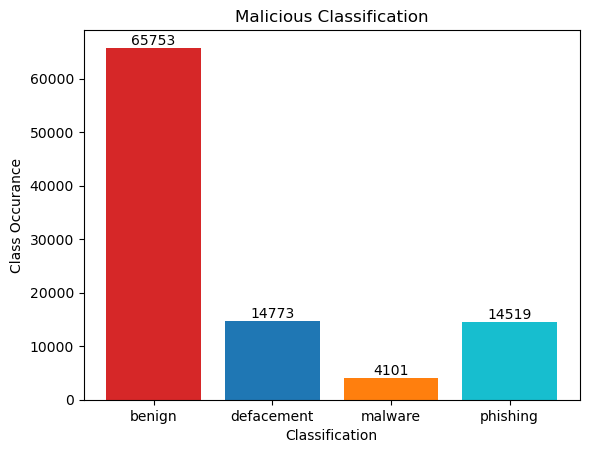

In [8]:
#Followed matplotlib website guide on 'Bar Chart with Individual Bar Colors' and customized by using value_count and accessing classification and counts.
# Y represents - mal_ds['Label']

label_counts = Y.value_counts() #counting the values of each class using value_count. This will return a series

bar_class = ['benign', 'defacement', 'malware', 'phishing']  
bar_counts = [label_counts.get(label,0) for label in bar_class]

bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:cyan']

figure, axis = plt.subplots() #assigning figure and axis for the bar plot

#Setting the x and y axis, applying color and title
axis.bar(bar_class, bar_counts, color=bar_colors)

axis.set_ylabel('Class Occurance')
axis.set_xlabel('Classification')
axis.set_title('Malicious Classification')


#using a for loop to show the count in numbers on each bar
for i, count in enumerate(bar_counts):
    axis.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()


### Descriptive Method : Visualization 2 - Bar Chart of Top 4 Domain-Suffixes in Dataset

This visualization displays the four most common domain suffixes in the dataset. Identifying frequently used suffixes helps see trends that could be used for feature extraction.

In [9]:

extractor = tldextract.TLDExtract(cache_dir=False) # disabling network access to avoid issues

NameError: name 'bar_suffix' is not defined

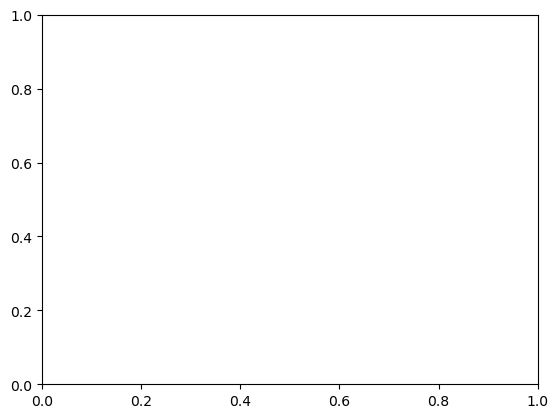

In [10]:
# X represents - mal_ds['URLs']
#creating a method to work on one URL at a time to extract the suffix and applying the method to the URLs column
# This method will also be used later on for feature extraction

def get_suffix(url):
    return tldextract.extract(url).suffix.lower()

extd_domains = X.apply(get_suffix)
top_domains = extd_domains.value_counts().head(4)
suffix_name = top_domains.index.tolist()
suffix_counts= top_domains.values
bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:cyan']

#plotting the histogram
figure, axis = plt.subplots()


axis.bar(bar_suffix, bar_count_suffix,color=bar_colors)
axis.set_ylabel('Count')
axis.set_xlabel('Domain Suffix')
axis.set_title('Top Four Domain-Suffix In Dataset')


#using a for loop to show the count in numbers on each bar
for i, count in enumerate(suffix_counts):
    axis.text(i,count, str(count), ha='center', va='bottom')
    
plt.show()


### Label Encoding - Dependent Variable, Y - Classifications

Since the labels are strings[benign, defacement, malware, phising], we need to convert those into numeric values so that the machine learning models can process them. Here, I'm using label encoding to assign a unique integer to each class.

In [11]:
# Y represents - mal_ds['Label']
le = preprocessing.LabelEncoder()
le.fit(Y)  # This is where the assignment of classes to numbers happens

#le.classes_ - allows us to view the labels
# le.transform - This maps the labels to the assigned values
le.classes_ 
le.transform(Y)

#Printing 

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

y = le.transform(Y)

print(type(y))

Label Mapping: {'benign': np.int64(0), 'defacement': np.int64(1), 'malware': np.int64(2), 'phishing': np.int64(3)}
<class 'numpy.ndarray'>


### Splitting Data into Train and Test Set

The training set will have 80% of the data, and the test set will have 20%. with 100,000 records available, 20% should be sufficient for testing. 
I used 'random_state = 42' to ensure that the same random split is made each time the program is run. This keeps the results consistent and reproducible.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 42)

Print statements to show the proper split

In [13]:
print(x_train[:5].values)
print(y_train[:5])
print(x_test[:5].values)
print(y_test[:5])
print(type(y_train))

['chesnay.homestead.com/files/ChesnayE-o/i34.htm'
 'normanmailertheamerican.com/story.html'
 'http://www.pret.im/0e7b22133f330d79e5add16645e3b74c/login.php'
 'www.angelfire.com/fl/FloridaConQuest/'
 'recreation.du.edu/jph/coaches/?t1=2&t2=81']
[0 0 3 3 0]
['canadianheadstones.com/qc/cemetery_pf.php?cemID=52'
 'communityfoodmoray.co.uk/'
 'thewrestlingpage.com/wrestling-history/the-rock-tells-jonathan-coachman-to-stop-singing/'
 'section15.ca/features/people/2001/05/09/cairine_wilson/'
 'forums.superiorpics.com/ubbthreads/ubbthreads.php/topics/3474518/Hayden_Panettiere_at_the_27th_']
[0 0 0 0 0]
<class 'numpy.ndarray'>


### Feature Extraction of URLs 

#### Feature Extraction Methods

Feature extraction is used to transform the raw URL into meaningful numeric information that the models can use. My feature extraction focuses on lexical features by analyzing the contents within the URL from different angles. These extractions give the models patterns to recognize during training. 
Since all of these methods return numeric values, no additional encoding is needed.

In [14]:
def get_url_length(url):  
    return len(url)

def count_digits(url):    
    return sum(c.isdigit() for c in url)

def equals_count(url):
    return url.count('=')

def question_count(url):
    return url.count('?')

def hyphen_count(url):
    return url.count('-')

def count_other_special_chars(url):
    pattern = r'[^a-zA-Z0-9=?-]'  #since equals, question mark and hyphen are counted separately, I'm excluding them in the count for special chars
    special_char = re.findall(pattern,url)
    count = len(special_char)
    return count
  
def https_check(url):
    return 1 if url.startswith("https") else 0

# A method to get the full domain e.g www.123.com. This method will be used in the domain_number_check method
def get_full_domain(url): 
    return tldextract.extract(url).fqdn
    

# A method to check if the entire domain is made of numbers and dots
# This will check if the domain is IP-like numbers, which can be an indicator of malicious intent in a URL.

def count_nums_in_domain(url): 
    domain = get_full_domain(url)
    digit_count = 0
    for char in domain:
        if char.isdigit():
            digit_count += 1
    return digit_count
    

#check if the domain is an IP address
def domain_is_ip(url):
    
    domain = get_full_domain(url)
    try: 
        ipaddress.ip_address(domain)
        return 1
    except ValueError:
        return 0

def suspicious_suffix(url):
    suffix = get_suffix(url)
    if suffix in ('',"info","cn","cc","asia","tk""biz","fm","tv","xyz","ml"):
        return 1 # if the domain suffix matches one of the suffixes in this list, return 1 -- indicating suspcious domain
    else:
        return 0  # if the domain suffix doesn't match..return 0


def count_suspicious(url):
    keywords = ["ebayisapi","webscr","rfc","webmail","login","re2","tech","css","servlet","urgent","confirm","images","signin","login","login2",
                "account","validate","reviews","activate","secure","blogs","crypto","pay","bank","fish","htm","php","view","free"]
    url = url.lower() 
    count = 0
    for word in keywords:
        if word in url:
            count += 1
    return count 
    

#### Testing Functionality of Feature Methods

A few test URLs were plugged into the methods to show that the methods return the expected output

In [15]:

test_urls = [
    "https://www.google.com",
    "https://www.alsothecrumbsplease.com/authentic-black-forest-cake",
    "http://sample.info/?drain=mine&direction=lock#cable",
    "http://bank-confirm.com/login",
    "https://www.sample.edu/?query.8"
]

for url in test_urls:
    print(f"URL: {url}")
    print("URL Length:", get_url_length(url))
    print("Digit Count:", count_digits(url))
    print("Special char count:", count_other_special_chars(url))
    print("Equals sign count:", equals_count(url))
    print("Question mark count:", question_count(url))
    print("Hyphen count:", hyphen_count(url))
    print("Suspicious keyword count:", count_suspicious(url))
    print("get_domin:", get_full_domain(url))
    print("Domain is IP?:", domain_is_ip(url))
    print("is domain number:", count_nums_in_domain(url))
    print("Domain Suffix: ", get_suffix(url)) #nothing being returned
    print("Suspicious suffix :", suspicious_suffix(url))

    print("-" * 50)




URL: https://www.google.com
URL Length: 22
Digit Count: 0
Special char count: 5
Equals sign count: 0
Question mark count: 0
Hyphen count: 0
Suspicious keyword count: 0
get_domin: www.google.com
Domain is IP?: 0
is domain number: 0
Domain Suffix:  com
Suspicious suffix : 0
--------------------------------------------------
URL: https://www.alsothecrumbsplease.com/authentic-black-forest-cake
URL Length: 63
Digit Count: 0
Special char count: 6
Equals sign count: 0
Question mark count: 0
Hyphen count: 3
Suspicious keyword count: 0
get_domin: www.alsothecrumbsplease.com
Domain is IP?: 0
is domain number: 0
Domain Suffix:  com
Suspicious suffix : 0
--------------------------------------------------
URL: http://sample.info/?drain=mine&direction=lock#cable
URL Length: 51
Digit Count: 0
Special char count: 7
Equals sign count: 2
Question mark count: 1
Hyphen count: 0
Suspicious keyword count: 0
get_domin: sample.info
Domain is IP?: 0
is domain number: 0
Domain Suffix:  info
Suspicious suffix : 


### Applying Features to Train and Test Set Dataframes

For this specific program, the feature extraction methods need to be applied to both the x_train and x_test sets because the model needs these numeric trends to make predictions. This does not cause data leakage, as the feature extractions operate on rows and no statistical generation was made.

In [16]:
#creating a data frame for x_train and x_test and adding the feature extractions as columns in the dataframe
# Used the pandas library to create the dataframes and apply the methods.

x_train_df = pd.DataFrame({
    'url_length': x_train.apply(get_url_length),
    'digit_counts': x_train.apply(count_digits),
    'equals_count' : x_train.apply(equals_count),
    'question_count' : x_train.apply(question_count),
    'hyphen_count' : x_train.apply(hyphen_count),
    'count_special_chars' : x_train.apply(count_other_special_chars),
    'https_check' : x_train.apply(https_check),
    'count_nums_in_domain' : x_train.apply(count_nums_in_domain),
    'domain_is_ip' : x_train.apply(domain_is_ip),
    'suspicious_suffix' : x_train.apply(suspicious_suffix),
    'count_suspicious' : x_train.apply(count_suspicious)
})

x_test_df = pd.DataFrame({
    'url_length' : x_test.apply(get_url_length),
    'digit_counts' : x_test.apply(count_digits),
    'equals_count' : x_test.apply(equals_count),
    'question_count' : x_test.apply(question_count),
    'hyphen_count' : x_test.apply(hyphen_count),
    'count_special_chars' :x_test.apply(count_other_special_chars),
    'https_check' : x_test.apply(https_check),
    'count_nums_in_domain' : x_test.apply(count_nums_in_domain),
    'domain_is_ip' : x_test.apply(domain_is_ip),
    'suspicious_suffix' : x_test.apply(suspicious_suffix),
    'count_suspicious' : x_test.apply(count_suspicious)
})

print("\nTop 5 rows of the extracted features for x_train \n")
display(x_train_df.head(5))

print("Top 5 rows of the extracted features for x_test \n")
display(x_test_df.head(5))



Top 5 rows of the extracted features for x_train 



,url_length,digit_counts,equals_count,question_count,hyphen_count,count_special_chars,https_check,count_nums_in_domain,domain_is_ip,suspicious_suffix,count_suspicious
52883,46,2,0,0,1,6,0,0,0,0,1
99868,38,0,0,0,0,3,0,0,0,0,1
37217,61,21,0,0,0,8,0,0,0,0,3
25419,37,0,0,0,0,5,0,0,0,0,0
87781,41,5,2,1,0,6,0,0,0,0,0


Top 5 rows of the extracted features for x_test 



,url_length,digit_counts,equals_count,question_count,hyphen_count,count_special_chars,https_check,count_nums_in_domain,domain_is_ip,suspicious_suffix,count_suspicious
77006,50,2,1,1,0,5,0,0,0,0,1
59864,25,0,0,0,0,3,0,0,0,0,0
26850,88,0,0,0,8,4,0,0,0,0,0
72888,55,10,0,0,0,9,0,2,0,0,0
84956,95,9,0,0,0,13,0,0,0,0,1


## Model Training, Test and Evaluation

Class weight was applied to improve the models' ability to detect phishing URLs. Since phishing URLs often closely resemble benign ones, it is harder to identify them. Therefore, class weight was doubled for phising URLs 

In [57]:
class_weights = {
    label_mapping["benign"]:1.0,
    label_mapping["defacement"]:1.0,
    label_mapping["malware"]:1.0,
    label_mapping["phishing"]:2.0
}

### Model 1 - Random Forest Classifier 

#### Training Model

In [58]:
random_forest = RandomForestClassifier(random_state = 42,class_weight=class_weights) 
random_forest.fit(x_train_df, y_train)

RandomForestClassifier(class_weight={np.int64(0): 1.0, np.int64(1): 1.0,
                                     np.int64(2): 1.0, np.int64(3): 2.0},
                       random_state=42)

#### Generating Predictions

In [59]:
y_pred_rf = random_forest.predict(x_test_df)

#### Evaluating Performance

Model Accurancy: 0.84

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     13131
           1       0.83      0.80      0.82      2983
           2       0.95      0.83      0.88       813
           3       0.62      0.57      0.59      2903

    accuracy                           0.84     19830
   macro avg       0.82      0.78      0.80     19830
weighted avg       0.84      0.84      0.84     19830



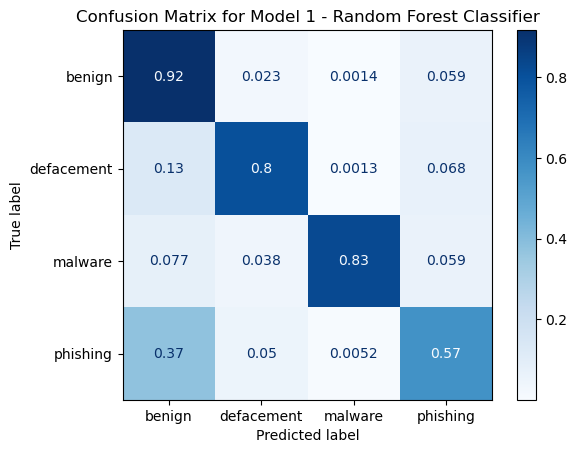

In [60]:
# Model accuracy measurement
accuracy = accuracy_score(y_test,y_pred_rf)
print(f"Model Accurancy: {accuracy:.2f}")

# Showing classification report
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred_rf))

# Plotting a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=le.classes_,cmap="Blues", normalize="true")
plt.title("Confusion Matrix for Model 1 - Random Forest Classifier")
plt.show()


### Model 2 : Hist Gradient Boosting Classifier

#### Training Model

In [61]:
hist_gbc= HistGradientBoostingClassifier(random_state = 42,class_weight=class_weights)
hist_gbc.fit(x_train_df, y_train)

HistGradientBoostingClassifier(class_weight={np.int64(0): 1.0, np.int64(1): 1.0,
                                             np.int64(2): 1.0,
                                             np.int64(3): 2.0},
                               random_state=42)

#### Generating Predictions

In [62]:
y_pred_hist=hist_gbc.predict(x_test_df)

#### Evaluating Performance

Model Accuracy: 0.84

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     13131
           1       0.84      0.78      0.81      2983
           2       0.96      0.80      0.87       813
           3       0.60      0.58      0.59      2903

    accuracy                           0.84     19830
   macro avg       0.82      0.77      0.79     19830
weighted avg       0.84      0.84      0.84     19830



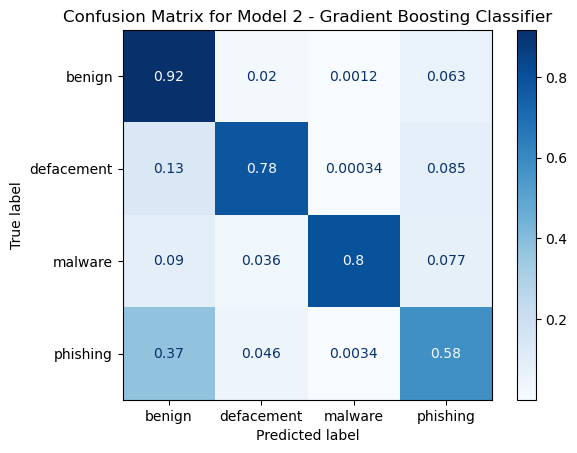

In [63]:
accuracy = accuracy_score(y_test,y_pred_hist)
print(f"Model Accuracy: {accuracy:.2f}")

# Showing classification report
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred_hist))

#Plotting a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_hist, display_labels=le.classes_,cmap="Blues", normalize="true")
plt.title("Confusion Matrix for Model 2 - Gradient Boosting Classifier")
plt.show()

### Model 3 : Logistic Regression

#### Training Model

In [64]:
log_model = LogisticRegression(random_state = 42,class_weight=class_weights)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_df)
x_test_scaled = scaler.transform(x_test_df)

log_model.fit(x_train_scaled, y_train)

LogisticRegression(class_weight={np.int64(0): 1.0, np.int64(1): 1.0,
                                 np.int64(2): 1.0, np.int64(3): 2.0},
                   random_state=42)

#### Generating Predictions

In [65]:
y_pred_log=log_model.predict(x_test_scaled)

#### Evaluating Performance

Model Accuracy: 0.73

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.95      0.83     13131
           1       0.76      0.43      0.55      2983
           2       0.75      0.54      0.63       813
           3       0.44      0.13      0.20      2903

    accuracy                           0.73     19830
   macro avg       0.67      0.51      0.55     19830
weighted avg       0.70      0.73      0.69     19830



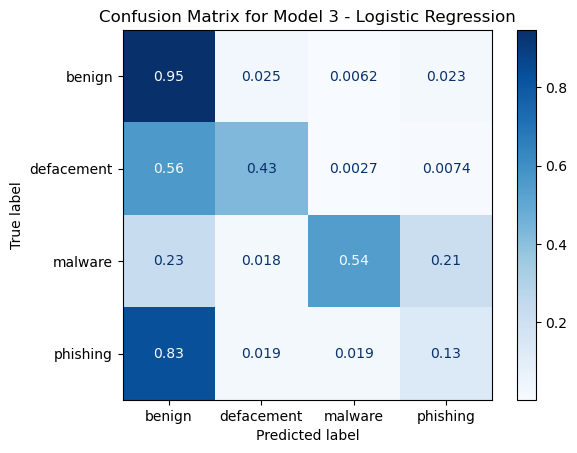

In [66]:

accuracy = accuracy_score(y_test,y_pred_log)
print(f"Model Accuracy: {accuracy:.2f}")


# Showing classification report
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred_log))

#Plotting a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, display_labels=le.classes_,cmap="Blues", normalize="true")
plt.title("Confusion Matrix for Model 3 - Logistic Regression")
plt.show()


## User Interface - URL Safety Checker

In [67]:
## URL Check: User Interaction

while True:
    
    user_url = input("\nPlease enter a URL to check for safety(or type q to quit:)\n\n")
    
    if user_url == 'q':
       print("Exiting URL checker.")
       break
    
    extracted_features = pd.DataFrame([{
        'url_length': get_url_length(user_url),
        'digit_counts': count_digits(user_url),
        'equals_count' : equals_count(user_url),
        'question_count' : question_count(user_url),
        'hyphen_count' : hyphen_count(user_url),
        'count_special_chars' : count_other_special_chars(user_url),
        'https_check' : https_check(user_url),
        'count_nums_in_domain' : count_nums_in_domain(user_url),
        'domain_is_ip' : domain_is_ip(user_url),
        'suspicious_suffix' : suspicious_suffix(user_url),
        'count_suspicious' : count_suspicious(user_url)
    }])
    
    prediction = random_forest.predict(extracted_features)[0]

    print("\n\nURL Safety Prediction: \n\n")
    
    if prediction == 0:
        print("Benign - Safe\n\n")
        
    if prediction == 1:
        print("Malicious - Possible Defacement\n\n")
        
    if prediction == 2:
        print("Malicious - Possible Malware\n\n")
    
    if prediction == 3:
        print("Malicious - Possible Phishing\n\n")
    



Please enter a URL to check for safety(or type q to quit:)

 q


Exiting URL checker.
